<a href="https://colab.research.google.com/github/tintubiel/ML_projects/blob/main/diplom_DS_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание температуры нагрева стали на этапе обработки.

<div style="border:solid #8A2BE2 2px; padding: 40px">

**Цель исследования**
    
Создание прототипа модели машинного обучения для предсказания температуры нагрева стали.
    
**Ход исследования**

* Загрузка и подготовка данных.
* Проведение предобработки данных.
* Формирование итогового признакового датасета.
* Обучение разных моделей и поиск лучшей.
* Проведение финального тестирования.

## 1. Загрузка и обзор данных

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMRegressor, plot_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from tqdm import tqdm
import warnings

In [ ]:
try:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas =  pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    data_gas =  pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [ ]:
warnings.filterwarnings("ignore")

### 1.1. Данные об электродах

In [ ]:
data_arc.info()
display(data_arc.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Как видим из данных, данные о начале и конце нагрева дугой представлены типом object, данный тип нужно преобразовать к более удобному в работе - datetime. Рассмотрим более подробно числовые признаки активной и реактивной мощностей

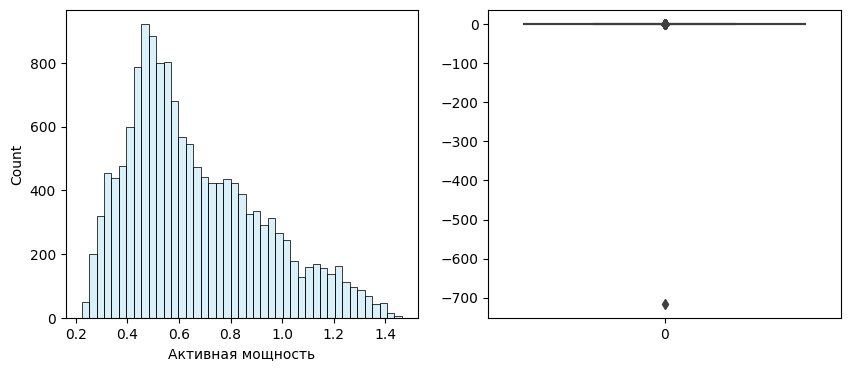

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(data_arc['Активная мощность'], ax=axes[0], color='skyblue',alpha = 0.3);
sns.boxplot(data_arc['Реактивная мощность'], ax=axes[1]);

Среди реактивных мощностей видим явный отрицательный выброс. Выведем строку, содержащую выброс. В дальнейшем объекты с данным ключом не будут рассматриваться.

In [ ]:
data_arc[data_arc['Реактивная мощность'] < -1]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Создадим список ключей, которые не должны войти в итоговую выборку.

In [ ]:
deleted_keys = []
deleted_keys.append(data_arc[data_arc['Реактивная мощность'] < -1]['key'])

In [ ]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

При первом обзоре есть предположение,что хранить даты и начала и конца избыточно. Проверим, отличаются ли даты начала и конца для каждого из объектов

In [ ]:
(data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.days.unique()

array([0])

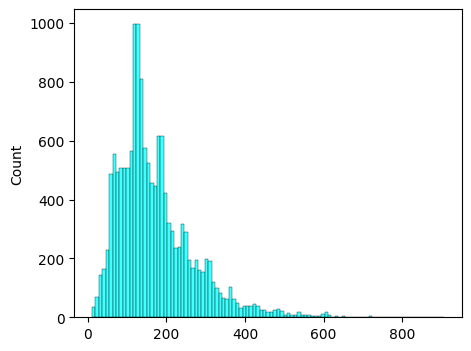

In [ ]:
plt.figure(figsize=(5,4))
ax = sns.histplot((data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds, color='cyan');

Смысла хранить даты в обоих полях нет. Также, предполагаю, что стоит создать признак длительности нагрева, а также признак, содержащий месяц нагрева (возможно погодные условия сказываются на температурее стали). Стартовые данные о дате начале и конце нагрева дугой после генерации этих признаков можно не рассматривать.

In [ ]:
data_arc['heat_time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

In [ ]:
agg_func_count = {'Активная мощность': ['mean'], 'Реактивная мощность': ['mean'], 'heat_time':['sum'], 'Начало нагрева дугой':['count']}
data_arc_new = data_arc.groupby(['key']).agg(agg_func_count).round(2)
data_arc_new.columns = ['active_power', 'reactive_power', 'heat_time', 'count_heats']
data_arc_new = data_arc_new.reset_index()
data_arc_new = data_arc_new[data_arc_new['key'] != 2116 ].reset_index(drop = True)
data_arc_new.head()

,key,active_power,reactive_power,heat_time,count_heats
0,1,0.61,0.43,1098,5
1,2,0.53,0.36,811,4
2,3,0.81,0.59,655,5
3,4,0.68,0.51,741,4
4,5,0.56,0.42,869,4


### 1.2 Данные о подаче сыпучих материалов (объём)

In [ ]:
data_bulk.info()
display(data_bulk.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Таким образом будем рассматривать все признаки, кроме 8го

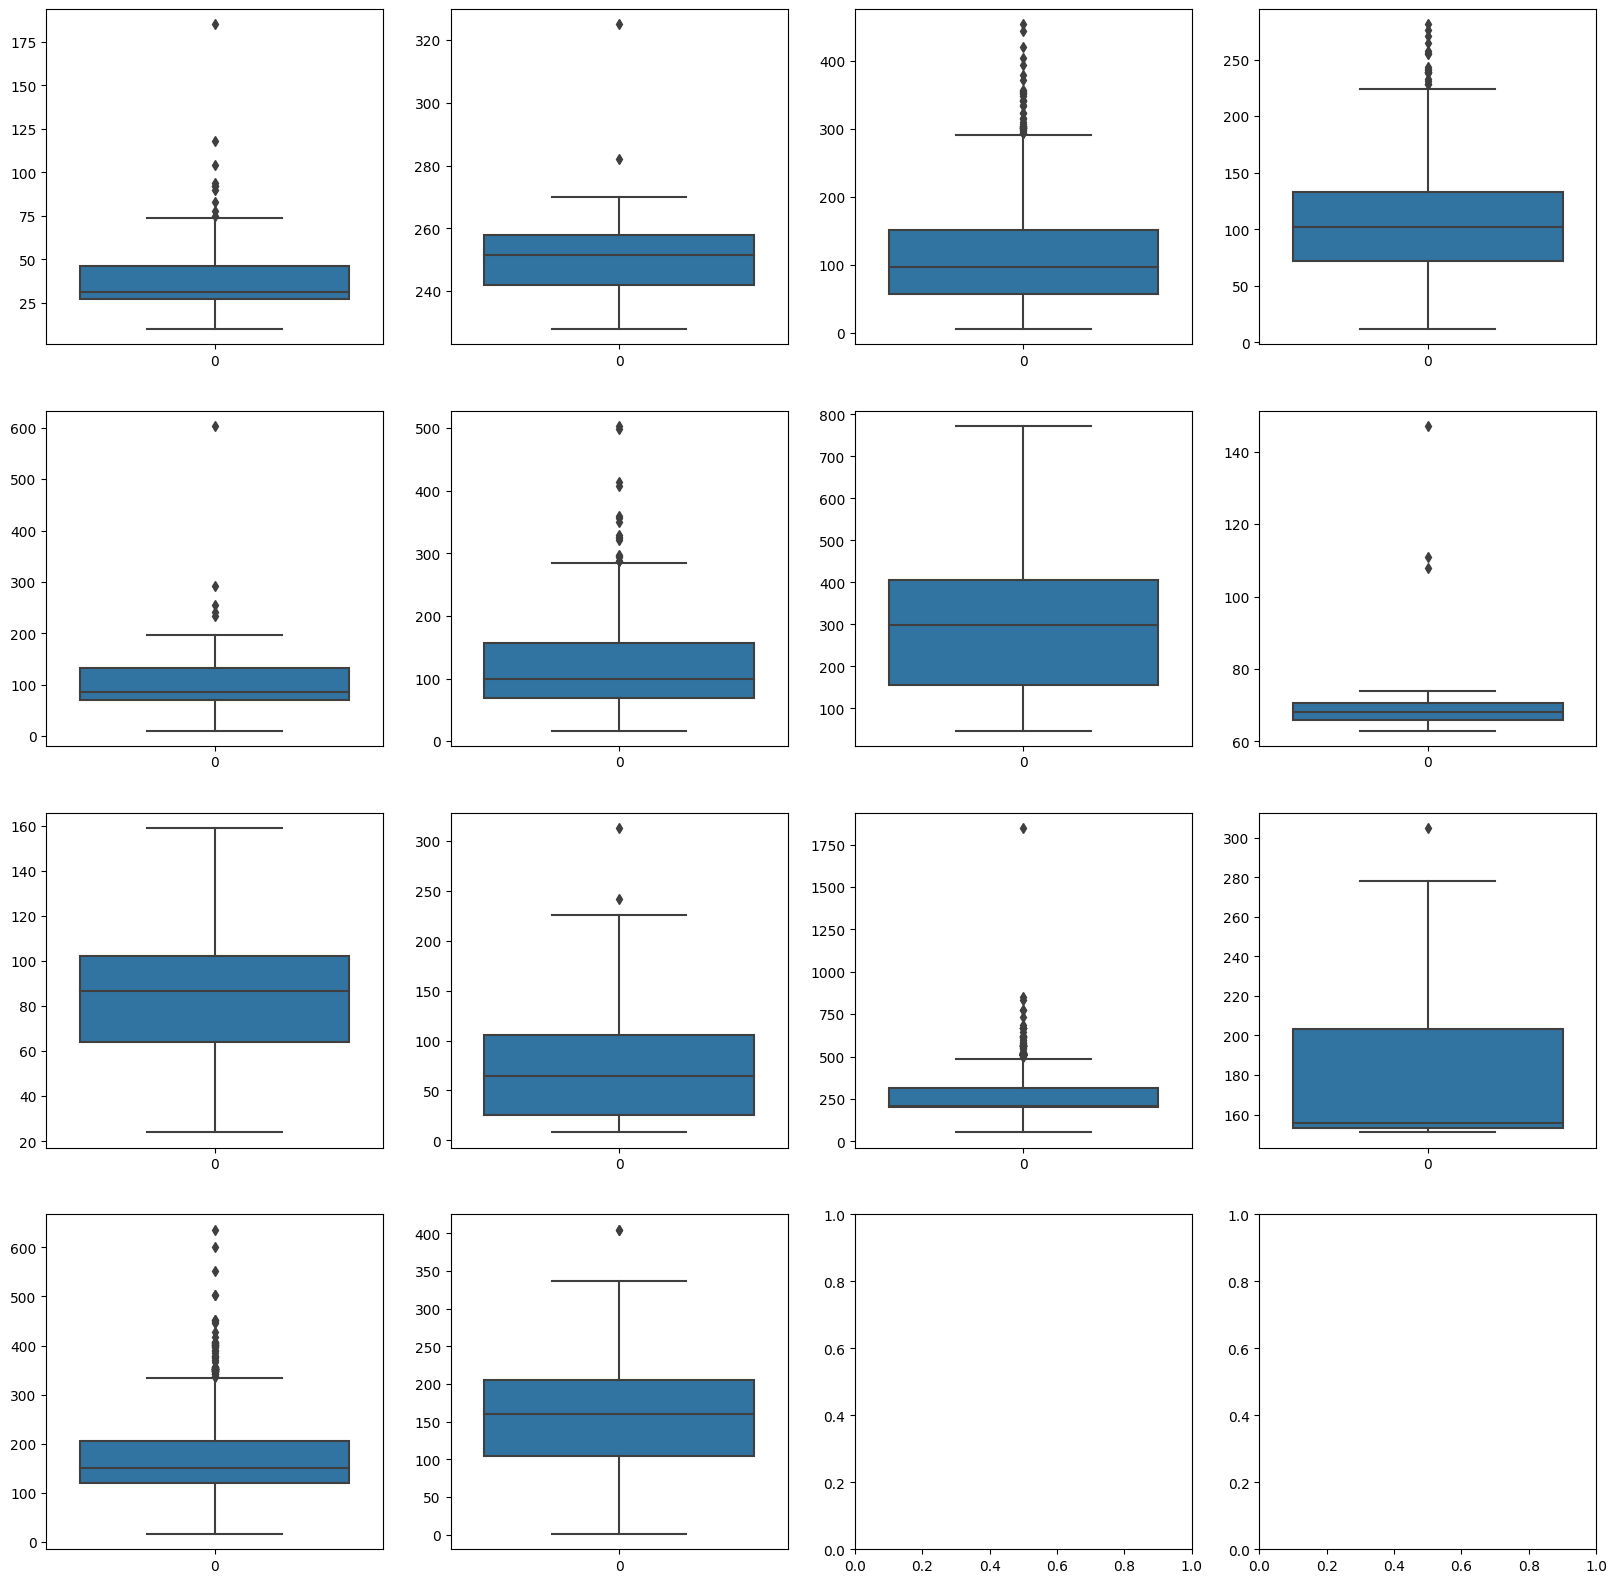

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20,20))
i=0
j=0
for num in [1,2,3,4,5,6,7,9,10,11,12,13,14,15]:
    if i<4:
        sns.boxplot(data_bulk['Bulk '+str(num)], ax=axes[j][i]);
        i+=1
    else:
        i=0
        j+=1
        sns.boxplot(data_bulk['Bulk '+str(num)], ax=axes[j][i]);
        i+=1


In [ ]:
data_bulk_new = data_bulk.drop(columns='Bulk 8')
data_bulk_new = data_bulk_new.fillna(0)
data_bulk_new.columns = ["_".join((element.lower()).split(" ")) for element in data_bulk_new.columns]
data_bulk_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### 1.3 Данные о подаче сыпучих материалов (время)

In [ ]:
data_bulk_time.info()
display(data_bulk_time.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Сохраним данные для признаков, отобранных в прошлом датасете. Преобразуем признаки к типу datetime.

In [ ]:
for num in [1,2,3,4,5,6,7,9,10,11,12,13,14,15]:
    name = 'Bulk ' + str(num)
    data_bulk_time[name] = pd.to_datetime(data_bulk_time[name])

In [ ]:
agg_func_count = {'Начало нагрева дугой':'min'}
temp = data_arc.groupby(['key']).agg(agg_func_count)
temp = temp.reset_index()

data_bulk_time_new = pd.DataFrame()
data_bulk_time_new['key'] = data_bulk_time['key']
for num in [1,2,3,4,5,6,7,9,10,11,12,13,14,15]:
    name = 'bulk_' + str(num)+'_time'
    data_bulk_time_new[name] = (data_bulk_time['Bulk '+ str(num)] - temp['Начало нагрева дугой']).dt.seconds


In [ ]:
data_bulk_time_new.head()

,key,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time
0,1,NaN,NaN,NaN,1594.0,NaN,NaN,NaN,NaN,NaN,NaN,1337.0,NaN,756.0,509.0
1,2,NaN,NaN,NaN,156.0,NaN,NaN,NaN,NaN,NaN,NaN,1156.0,NaN,863.0,625.0
2,3,NaN,NaN,NaN,1545.0,NaN,NaN,NaN,NaN,NaN,NaN,1219.0,NaN,847.0,562.0
3,4,NaN,NaN,NaN,225.0,NaN,NaN,NaN,NaN,NaN,NaN,1103.0,NaN,694.0,419.0
4,5,NaN,NaN,NaN,1174.0,NaN,NaN,NaN,NaN,NaN,NaN,1174.0,NaN,1379.0,1174.0


### 1.4 Данные о продувке сплава газом

In [ ]:
data_gas.info()
display(data_gas.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


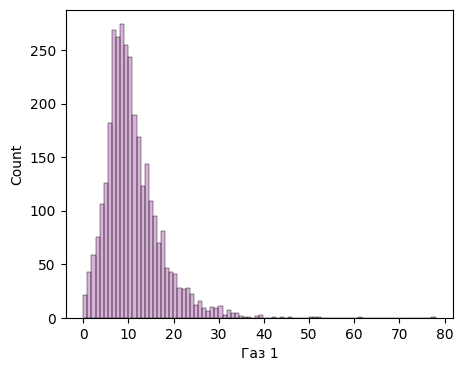

In [ ]:
plt.figure(figsize=(5,4))
ax = sns.histplot(data_gas['Газ 1'], color='purple', alpha = 0.3);

В целом, на графике есть некоторые значения, похожие на выбросы. В ходе создания модели решим,как именно с ними поступить.

In [ ]:
data_gas.columns = ['key','gas_1']

### 1.5  Данные о проволочных материалах (объём)

In [ ]:
data_wire.info()
display(data_wire.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


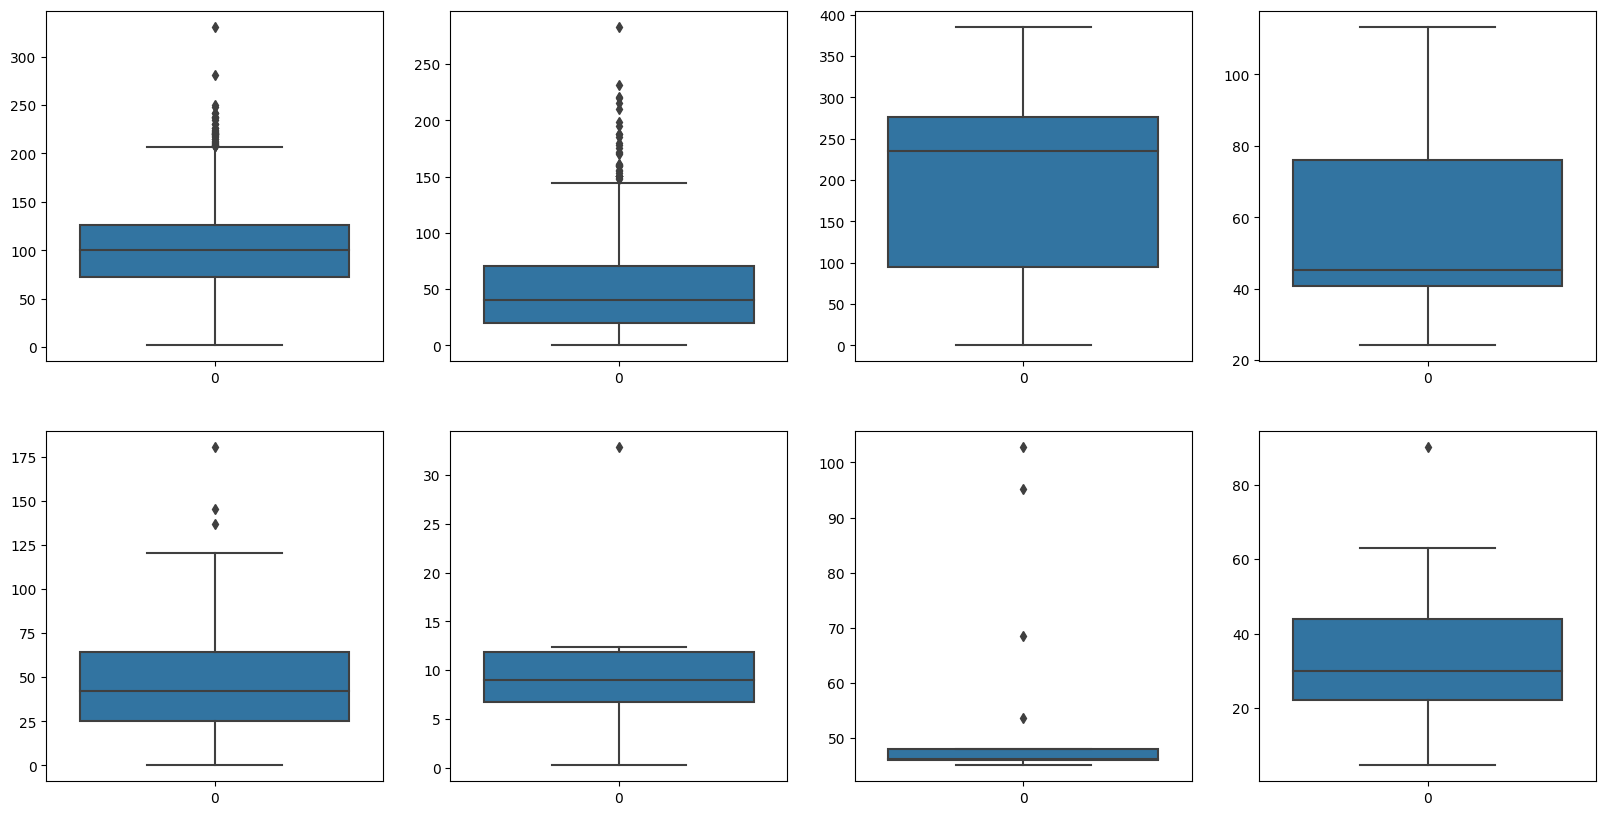

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
i=0
j=0
for num in [1,2,3,4,6,7,8,9]:
    if i<4:
        sns.boxplot(data_wire['Wire '+str(num)], ax=axes[j][i]);
        i+=1
    else:
        i=0
        j+=1
        sns.boxplot(data_wire['Wire '+str(num)], ax=axes[j][i]);
        i+=1

In [ ]:
data_wire_new = data_wire.drop(columns = 'Wire 5')
data_wire_new.columns = ["_".join((element.lower()).split(" ")) for element in data_wire_new.columns]
data_wire_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN


### 1.6  Данные о проволочных материалах (время)

In [ ]:
data_wire_time.info()
display(data_wire_time.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Сохраним данные для признака, отобранного в прошлом датасете. Преобразуем признак к типу datetime.

In [ ]:
for num in [1,2,3,4,6,7,8,9]:
    data_wire_time['Wire '+ str(num)] = pd.to_datetime(data_wire_time['Wire '+ str(num)])

In [ ]:
data_wire_time_new = pd.DataFrame()
data_wire_time_new['key'] = data_wire_time['key']

for num in [1,2,3,4,6,7,8,9]:
    data_wire_time_new['wire_'+ str(num)+'_time'] = (data_wire_time['Wire '+str(num)] - temp['Начало нагрева дугой']).dt.seconds

data_wire_time_new.head()

,key,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time
0,1,245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,292.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,571.0,261.0,NaN,NaN,NaN,NaN,NaN,NaN


### 1.7  Данные о температуре

In [ ]:
data_temp.info()
display(data_temp.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


В качестве признака разрешено брать только начальную температуру, соответственно выделим из этого датафрейма температуру для каждого ключа с самым ранним временем. Температуру с самым поздним временем нам предстоит предсказать.

In [ ]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'] )

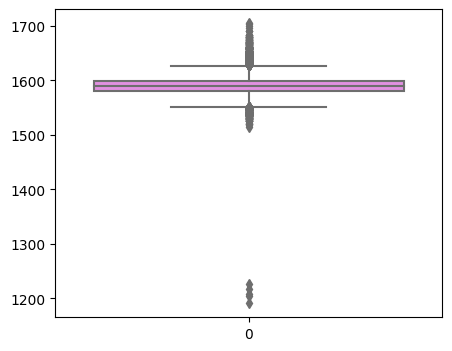

In [ ]:
plt.figure(figsize=(5,4))
ax = sns.boxplot(data_temp['Температура'], color='violet')

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [ ]:
tmp_min = pd.pivot_table(data_temp,
               index=["key"],
               values=['Время замера'],
               aggfunc = ['min']).reset_index()
tmp_min.columns = ['key', 'Время замера']

tmp_1 = pd.merge(tmp_min, data_temp, how="inner", on=['key','Время замера'])
tmp_1.columns = ['key', 'start_time', 'start_temp']

tmp_max = pd.pivot_table(data_temp,
               index=["key"],
               values=['Время замера'],
               aggfunc = ['max']).reset_index()
tmp_max.columns = ['key', 'Время замера']

tmp_2 = pd.merge(tmp_max, data_temp, how="inner", on=['key','Время замера'])
tmp_2.columns = ['key', 'stop_time', 'stop_temp']

data_temp_new = pd.merge(tmp_1,tmp_2,how="inner",on=['key'])
data_temp_new['delta_time_check'] = (data_temp_new['stop_time'] - data_temp_new['start_time']).dt.seconds
data_temp_new['delta_time_heat'] = (data_temp_new['stop_time'] - temp['Начало нагрева дугой']).dt.seconds
data_temp_new.head()

,key,start_time,start_temp,stop_time,stop_temp,delta_time_check,delta_time_heat
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714,1704.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265,1255.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753,1743.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220,1210.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536,1526.0


Найдем значения, в которых только одно измерение. Для таких значений время начала и конца измерений температуры совпадает.

In [ ]:
data_temp_new[data_temp_new['start_time']==data_temp_new['stop_time']]
deleted_keys.append(data_temp_new[data_temp_new['start_time']==data_temp_new['stop_time']]['key'])

Найдем значения, для которых температура ниже 1500.

In [ ]:
data_temp_new[(data_temp_new['start_temp']<1500)|(data_temp_new['stop_temp']<1500)]
deleted_keys.append(data_temp_new[(data_temp_new['start_temp']<1500)|(data_temp_new['stop_temp']<1500)]['key'])

Данные из получившейся таблицы, содержащие пропуски будут удалены.

In [ ]:
data_temp_new = data_temp_new.dropna().reset_index(drop=True)
data_temp_new = data_temp_new.drop(columns = ['start_time','stop_time'])
data_temp_new.head()

,key,start_temp,stop_temp,delta_time_check,delta_time_heat
0,1,1571.0,1613.0,1714,1704.0
1,2,1581.0,1602.0,1265,1255.0
2,3,1596.0,1599.0,1753,1743.0
3,4,1601.0,1625.0,1220,1210.0
4,5,1576.0,1602.0,1536,1526.0


### 1.8  Итоговый датасет

In [ ]:
dfs = [data_temp_new,
       data_bulk_time_new,
       data_bulk_new,
       data_gas,
       data_arc_new,
       data_wire_new,
       data_wire_time_new]

final_df = reduce(lambda  left,right: pd.merge(left,right,on=['key'], how='inner'), dfs)

In [ ]:
final_df = final_df[~final_df['key'].isin(deleted_keys)]
final_df = final_df.drop(columns = 'key')
final_df.head()
final_df.isna().sum()

start_temp             0
stop_temp              0
delta_time_check       0
delta_time_heat        0
bulk_1_time         2129
bulk_2_time         2315
bulk_3_time         1368
bulk_4_time         1516
bulk_5_time         2275
bulk_6_time         1891
bulk_7_time         2315
bulk_9_time         2315
bulk_10_time        2185
bulk_11_time        2198
bulk_12_time         516
bulk_13_time        2314
bulk_14_time         261
bulk_15_time         629
bulk_1                 0
bulk_2                 0
bulk_3                 0
bulk_4                 0
bulk_5                 0
bulk_6                 0
bulk_7                 0
bulk_9                 0
bulk_10                0
bulk_11                0
bulk_12                0
bulk_13                0
bulk_14                0
bulk_15                0
gas_1                  0
active_power           0
reactive_power         0
heat_time              0
count_heats            0
wire_1                23
wire_2              1517
wire_3              2289


In [ ]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
start_temp,2328.0,1586.722079,28.296417,1191.000000,1571.000000,1587.000000,1603.000000,1660.000000
stop_temp,2328.0,1593.371993,11.198791,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
delta_time_check,2328.0,2323.161512,1385.132093,339.000000,1580.500000,2047.000000,2791.500000,23674.000000
delta_time_heat,2328.0,76331.362543,21152.546155,746.000000,81202.250000,82787.000000,83718.750000,86330.000000
bulk_1_time,199.0,41409.944724,22882.758642,135.000000,21785.500000,43273.000000,57678.000000,86248.000000
bulk_2_time,13.0,51558.692308,21739.030166,22444.000000,36128.000000,48992.000000,76024.000000,84203.000000
bulk_3_time,960.0,42068.181250,23929.581373,78.000000,22435.750000,42447.000000,61353.500000,86320.000000
bulk_4_time,812.0,42457.250000,23832.689366,124.000000,21532.250000,46823.500000,60612.500000,86339.000000
bulk_5_time,53.0,45876.056604,19850.365313,1365.000000,30351.000000,47531.000000,59980.000000,78982.000000
bulk_6_time,437.0,38915.183066,24751.264729,138.000000,15570.000000,36809.000000,58143.000000,86267.000000


**Выводы:**

По итогу раздела осуществлен обзор данных, анализ и предобработка данных. Произведено формирование признакового датасета для работы модели.

## 2. Подготовка модели

### 2.1 Разделение на тренировочную и тестовую выборки

In [ ]:
features = final_df.drop(columns = 'stop_temp')
target = final_df['stop_temp']

In [ ]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.25, random_state=20623, shuffle=True)

In [ ]:
print("Размеры тренировочной и тестовой выборок:")
print(train_features.shape,test_features.shape)

Размеры тренировочной и тестовой выборок:
(1746, 52) (582, 52)


### 2.2 Обработка пропусков в данных

In [ ]:
for column in train_features.columns:
    train_features[column] = train_features[column].fillna(train_features[column].median())
    test_features[column] = test_features[column].fillna(test_features[column].median())

### 2.3 Проверка дубликатов в данных

In [ ]:
print(train_features.duplicated().sum())
print(test_features.duplicated().sum())

0
0


Явные дубликаты в данных отсутсвуют

**Выводы:**

По итогу раздела был осуществлен обзор итогового датафрейма,проведена окончательная предобработка данных. Найденные пропуски были заполнены, произведена проверка на наличие дубликатов. Обработка выбросов не производилась, т.к. заданные признаки требуют экспертной оценки. Мультиколлинеарность признаков также не рассматривалась в связи с тем, что модели, используемые для предсказания не снижают свое качество при наличии мультиколлинеарности.

## 3. Построение модели

### 3.1. Маштабирование признаков

In [ ]:
scaler = StandardScaler()

scaler.fit(train_features)
train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)

Данные всех выборок отмаштабированы при помощи StandartScaler.

### 3.2 RidgeCV Regression model

**Без применения метода главных компонент**

In [ ]:
from sklearn.linear_model import RidgeCV
model = RidgeCV(alphas=[0.001,0.01,1,10])

model.fit(train_features_scaled,train_target)
print('Среднее значение метрики на тренировочной выборке:', (-1) * np.mean(cross_val_score(model, train_features_scaled , train_target, scoring='neg_mean_absolute_error', cv=5)))


Среднее значение метрики на тренировочной выборке: 6.410628714701387


**С применением метода главных компонент**

In [ ]:
pca = PCA()
pca_train_features = pca.fit_transform(train_features_scaled)
explained_variance = pca.explained_variance_ratio_


In [ ]:
def pca_plot(train_features, train_target, k):

    score_list=[]
    for n in tqdm(range(1,k)):
        model = RidgeCV(alphas=[0.01], scoring='neg_mean_absolute_error', cv=5)
        pca = PCA(n_components=n)

        pca_train_features=pca.fit_transform(train_features)
        model.fit(pca_train_features, train_target)
        score_list.append((-1)*np.mean(cross_val_score(model, pca_train_features, train_target, scoring='neg_mean_absolute_error', cv=5)))

    fig, axs = plt.subplots(1,1, figsize=(8,4))
    fig.suptitle('Зависимость метрики от количества признаков',fontsize=10)
    axs.scatter(x=range(1,k), y=score_list, color='darkviolet')

    val, idx = min((val, idx) for (idx, val) in enumerate(score_list))
    plt.show()

    print('Наилучшее значение метрики на тренировочной выборке:', val, ', при количестве признаков:', idx+1)

100%|██████████| 51/51 [00:07<00:00,  6.45it/s]


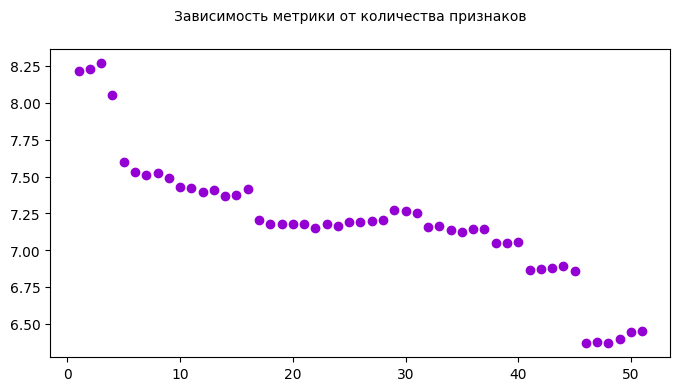

Наилучшее значение метрики на тренировочной выборке: 6.3698487355100495 , при количестве признаков: 46


In [ ]:
pca_plot(train_features_scaled, train_target, len(explained_variance))

Модель RidgeCV Regression применена к полному перечню маштабированных признаков и к отобранному при помощи метода главных компонент набору наиболее важных признаков. Приведены визуализации, показывающие, как количество рассматриваемых признаков влияет на качество модели. Применение метода главных компонент показало, что лучший результат модель показывает при количестве признаков, равном 46.
* Значение метрики для RidgeCV Regression **6.41**
* Значение метрики для RidgeCV Regression при использовании PCA **6.36**

### 3.3 Модель дерева решений и случайного леса

In [ ]:
models=[DecisionTreeRegressor(random_state=20623), RandomForestRegressor(random_state=20623)]
grid = [{'max_depth': range(1,10)},{'n_estimators': range (10, 101, 10),'max_depth': range (1,5)}]

In [ ]:
def apply_gridsearch_cv(models, grid, train_f, train_t):
    best_params=[]
    score_list=[]

    for i in  range(len(models)):
        grid_cv = GridSearchCV(estimator=models[i], param_grid = grid[i] ,scoring='neg_mean_absolute_error',cv = 5, verbose=0)
        grid_cv.fit(train_f, train_t)

        print("best model:",grid_cv.best_estimator_)

        train_score = grid_cv.best_score_

        print('Наилучшее значение метрики на тренировочной выборке:', train_score)
        print("\n")

        best_params.append(grid_cv.best_params_)
        score_list.append(np.mean(train_score))

    return (best_params)

In [ ]:
apply_gridsearch_cv(models, grid, train_features_scaled, train_target)

best model: DecisionTreeRegressor(max_depth=6, random_state=20623)
Наилучшее значение метрики на тренировочной выборке: -7.2796655516003455


best model: RandomForestRegressor(max_depth=4, n_estimators=80, random_state=20623)
Наилучшее значение метрики на тренировочной выборке: -6.717797757407792




[{'max_depth': 6}, {'max_depth': 4, 'n_estimators': 80}]

При подборе гиперпараметров при помощи GridSeachCV было получено, что среди моделей Дерева решений и Случайного леса лучшее значение MAE  на тренировочной выборке имеет модель **RandomForestRegressor(max_depth=4, n_estimators=80)**.
* Значение MAE составляет: **6.7**

### 3.4 Модель LGBMR

Среднее значение метрики на тренировочной выборке: 5.930992714274865


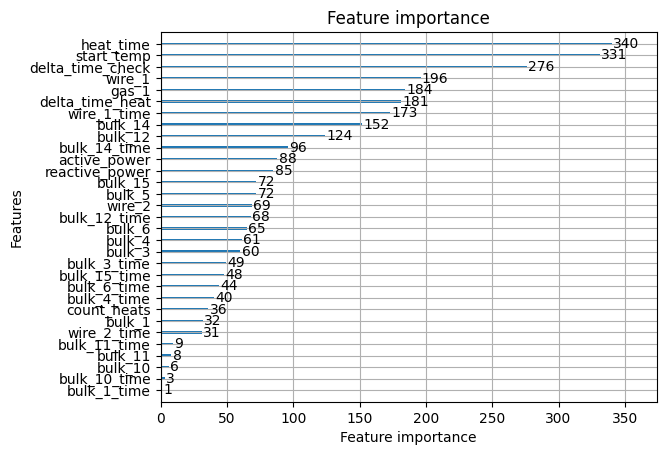

In [ ]:
model = LGBMRegressor(random_state=20623)
train_features_df = pd.DataFrame(data=train_features_scaled,
                                 columns=train_features.columns)
model.fit(train_features_df, train_target)
plot_importance(model)
print('Среднее значение метрики на тренировочной выборке:', (-1) * cross_val_score(model, train_features_scaled , train_target, scoring='neg_mean_absolute_error', cv=5).mean())


In [ ]:
model = LGBMRegressor(random_state=20623)
params = {'learning_rate':[0.1],'min_child_samples':range(1,6), "n_estimators":[50, 100, 200]}
gr_s = GridSearchCV(model, params, scoring = 'neg_mean_absolute_error', cv=5, verbose=0)
gr_s.fit(train_features_scaled, train_target)

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=20623),
             param_grid={'learning_rate': [0.1],
                         'min_child_samples': range(1, 6),
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error')

In [ ]:
print(gr_s.best_params_)
print("Значение MSE на тренировочной выборке:", (-1)*gr_s.best_score_)

{'learning_rate': 0.1, 'min_child_samples': 5, 'n_estimators': 100}
Значение MSE на тренировочной выборке: 5.798429578018839


По результатам тестирования лучшее значение метрики на тренировочных данных было получено у модели LGBMRegressor. Визуализированные наиболее важные признаки для данной модели.

* Значение MAE составляет: **5.8**

**Выводы**:

В ходе моделирования были рассмотрены четыре регрессионные модели: линейная модель с регуляризацией, модель дерев решений, модель случайного леса и модель на основе градиентного бустинга. Для последних трех моделей был произведен подбор гиперпараметров перебором по сетке.

Лучшее значение метрики было получено при использовании бустинговой модели
 **LGBMRegressor(learning_rate = 0.1, min_child_samples = 5, n_estimators = 100, random_state=20623)**



## 4. Проведение финального тестирования.

### 4.1. Лучшая модель

In [ ]:
best_model = LGBMRegressor(learning_rate = 0.1, min_child_samples = 5, n_estimators = 100, random_state=20623)
best_model.fit(train_features_scaled, train_target)
test_predictions = best_model.predict(test_features_scaled)
best_score = mean_absolute_error(test_predictions, test_target)
print("Значение MAE на тестовой выборке", best_score)

Значение MAE на тестовой выборке 5.907146677124523


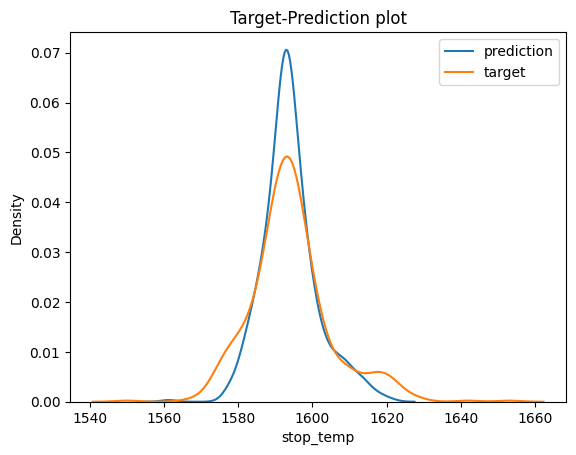

In [ ]:
sns.kdeplot(test_predictions, label='prediction')
sns.kdeplot(test_target, label='target')
plt.title("Target-Prediction plot")
plt.legend();

### 4.2 Константная модель

In [ ]:
dummy_model = DummyRegressor()

dummy_model.fit(train_features_scaled, train_target)
test_predictions = dummy_model.predict(test_features_scaled)
best_score = mean_absolute_error(test_predictions, test_target)
print(best_score)

7.8493522750085605


**Выводы:**

По итогу раздела при применении лучшей модели к тестовым данным получено итоговое значение MAE на тестовой выборке, равное **5.9**, что показывает значительный результат в сравнении с константной моделью. Сравнивая значение метрики на тренировочных и тестовых данных видим, что полученная модель отлично адаптирутся под незнакомые данные и не переобучается.

## 5. Выводы

Задачей исследования было построение модели предсказания определения температуры стали на этапе обработки. Значение метрики MAE должно составлять менее 6.8.

В ходе исследования были изучены предоставленные данные, произведена предобработка данных, включая проверку на пропуски, дубликаты и маштабирование признаков. Были сгенерированы дополнительные признаки на основе имеющейся информации, которые вошли в итоговый обучающий датасет.

Общий объем данных сократился после предобработки на **23%**. Ключевым поводом для выведения партий из рассмотрения являлось отсутствие конечной температуры, которая является целевым признаком исследования.

Были рассмотрены несколько регрессионных моделей машинного обучения: **RidgeCV, DecisionTreeRegressor, RandomForestRegressor**, **LightGBM**. Для алгоритма **RidgeCV** было проверено качество модели на всех параметрах, а также на части параметров, отобранных при помощи метода **PCA**. Для остальных моделей были подобранны гиперпараметры при помощи перебора по сетке с использованием кросс-валидации. По итогам рассмотрения для наилучшей модели представлен **график важности параметров**. Затем модель, проявившая себя лучше всего на тренировочных данных была применена к тестовому множеству.
    
****

**RidgeCV**
Модели на основе данного алгоритма показали схожие результаты при применении к общему пулу признаков и при применении к признакам, отобранным при помощи PCA.
* Значение MAE составляет: **6.41**
* Значение MAE при использовании PCA составляет: **6.36**

**DecisionTreeRegressor**
Модели на основе данного алгоритма показали неудовлетворительные результаты.
* Значение MAE составляет: **7.2**

**RandomForestRegressor**
Модели на основе данного алгоритма показали неудовлетворительные результаты.
* Значение MAE составляет: **6.7**

**LightGBM**
Модель на основе данного алгоритма позволила визуализировать значимость признаков для модели. Рассматриваемая модель показала наилучшие результаты на тренировочных данных.  
По результатам подбора гиперпараметров лучшей была признана модель:
**LGBMRegressor(learning_rate = 0.1, min_child_samples = 5, n_estimators = 100, random_state=20623)**
  
* Значение MAE составляет: **5.8**
    
**Применение к тестовой выборке**
    
В ходе применения лучшей модели к тестовой выборке было получено итоговое значение MAE, равное **5.9**, что показывает способность модели абстрагироваться от обучающих данных


##  6. Отчет о проекте

### **Отчет о проекте: Образец модели машинного обучения для набора данных регрессии температуры нагрева стали на этапе обработки.**

### 1. Понимание бизнеса
**Определение проблемы**

Набор данных для этого проекта получен от команды Яндекс.Практикума в качестве выпускной работы.

При помощи разработанной программы моделируется технологический процесс плавления стали, включающий в себя этапы добавления легирующих материалов и продувание сплава инертным газом. Помимо рассмотренного выше функционала модель позволит выделить наиболее важные признаки влияющие на нагрев и
конечную температуру. После внедрения модели ожидается снижение потребление электроэнергии на этапе обработки за счет контолируемого нагрева стали.

**Область применения**

Модель разработана для конкретного предприятия и моделируемого технологического процесса. При изменении этапов процесса модель может выдавать некорректный результат.

**Показатели**

Производительность модели машинного обучения будет оцениваться на тестовом наборе данных, выделенного из общего набора. Показателем качества модели считается метрика MAE. При достижении значения метрики ниже порогового уровня 6.8 модель считается подходящей для внедрения.
_______________________________
### 2. Сбор и понимание данных

**Исходные данные**

Исходные данные представлены набором файлов, содержащих информацию о различных технологических характеристиках процесса плавления стали.

- `data_arc_new.csv` — данные об электродах;
    
    Размер датасета : (14876, 5)
    * **key** - номер партии
    * **Начало нагрева дугой**	- дата и время начала нагрева
    * **Конец нагрева дугой** - дата и время окончания нагрева
    * **Активная мощность**	- значение активной мощности для данной итерации нагрева
    * **Реактивная мощность** - значение реактивной мощности для данной итерации нагрева
    

- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);

    Размер датасета : (3129, 16)
    * данные об объеме добавления пятнадцати различных сыпучих материалов
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);

    Размер датасета : (3129, 16)
    * данные о времени добавления пятнадцати различных сыпучих материалов
- `data_gas_new.csv` — данные о продувке сплава газом;

    Размер датасета : (3239, 2)
    * **key** - номер партии
    * **Газ 1**	- данные о продувке данной партии инертным газом
- `data_temp_new.csv` — результаты измерения температуры;

    Размер датасета : (18092, 3)
    * **key** - номер партии
    * **Время замера**	- дата и время измерения температуры
    * **Температура** - значение температуры для данной итерации измерения
- `data_wire_new.csv` — данные о проволочных материалах (объём);

    Размер датасета : (3081, 10)
    * данные об объеме добавления девяти различных проволочных материалов
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

    Размер датасета : (3081, 10)
    * данные о времени добавления девяти различных проволочных материалов
____________________________
### 2. Моделирование

#### Разработка функциональных возможностей

**Очистка данных**

При внимательном изучении данных были выявлены отрицательные значения реактивной мощности в данных об электродах` и температуры менее 1500 градусов в данных с результатами измерения температуры. Партии, в которых выявлены
аномальные значения, не рассматриваются в исследовании. Помимо этого не рассматриваются партии, для которых температура была измерена единожды или конечная температура неизвестна.
Из рассмотрения удалены стержневые и сыпучие материалы, которые были использованы единожды. Неизвестные значения в объемах оставшихся материалов были заменены нулями. Из всех признаков, содержащих даты и время были сгенерированы новые признаки, после чего значения, сожержащие даты, не участвовали в рассмотрении.

**Генерация признаков**

На основании имеющихся данных были сгенерованы новые признаки, которые использовались при обучении модели.

На основе информации об электродах

* **heat_time** - суммарное время нагрева дугой по партии
* **count_heats** - количество итераций нагрева для конкретной партии
* **active_power** - средняя активная мощность
* **reactive_power** - средняя реактивная мощность

На основе информации о времени добавления сыпучих и проволочных веществ:

* **bulk_num_time** - временная разница между началом нагрева и добавлением соответствующего сыпучего материала
* **wire_num_time** - временная разница между началом нагрева и добавлением соответствующего проволочного материал.

Часть полученных признаков содержала пропуски, которые были обработаны отдельно для тренировочной и тестовой выборок и заменены средним значением для конкретного вещества.

На основании данных о температуре:

* **start_temp** - температура, соответствующая первому измерению для партии
* **stop_temp**	- температура, соответствующая последнему измерению для партии
* **delta_time_check** - временная разница между первым и последним измерением температуры
* **delta_time_heat** - временная разница между началом нагрева  и последним измерением температуры

**Стандартизация числовых признаков**

Числовые характеристики были стандартизированы при помощи иеструмента StandartScaler(). Обучение функции-стандартизатора прозводилось на тренировочных данных, затем тестовые и тренировочные данные были приведены к соответствующему маштабу.

**Формирование набора данных для ввода в моделирование**

####Обучение моделированию
В ходе реализации были построены четыре модели с перекрестной проверкой:
* Модель линейной регрессии с L2-регуляризаией `RidgeCV Regression`
    * Модель рассмотрена отдельно и с применением метода главных компонент. Метод главных компонент проявил наилучшее качество при количестве признаков, равном 46.
* Модель дерева решений `DescitionTreeRegressor`
    * Для модели произведен перебор гиперпараметров по сетке на множестве из 45 точек
* Модель случайного леса `RandomForestRegressor`
    * Для модели произведен перебор гиперпараметров по сетке на множестве из 200 точек
* Модель на основе градиентного бустинга `LightGBM`
    * Для модели произведен перебор гиперпараметров по сетке на множестве из 75 точек

#### Оценка модели

Лучше всего на тренировочных данных проявила себя бустинговая модель LightGBM. Рассматриваемая модель получила оценку метрики MAE 5.9 на тестовых данных.
По полученным прогнозам был построен график, отражающий точность предсказаний:

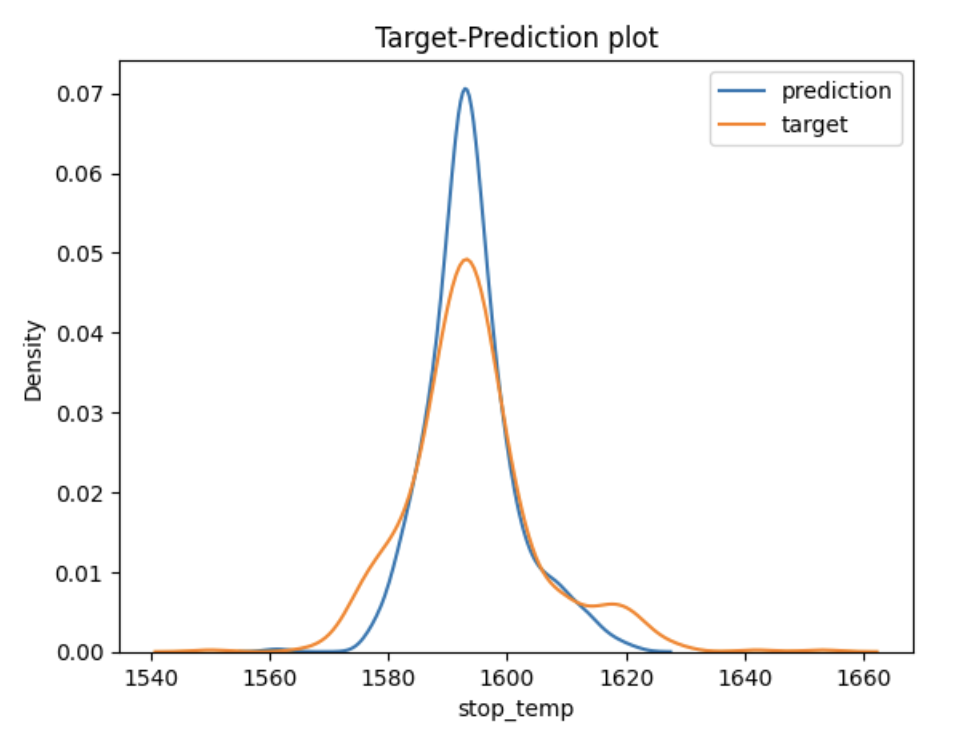

Для рассматриваемой модели был построен график важности признаков:

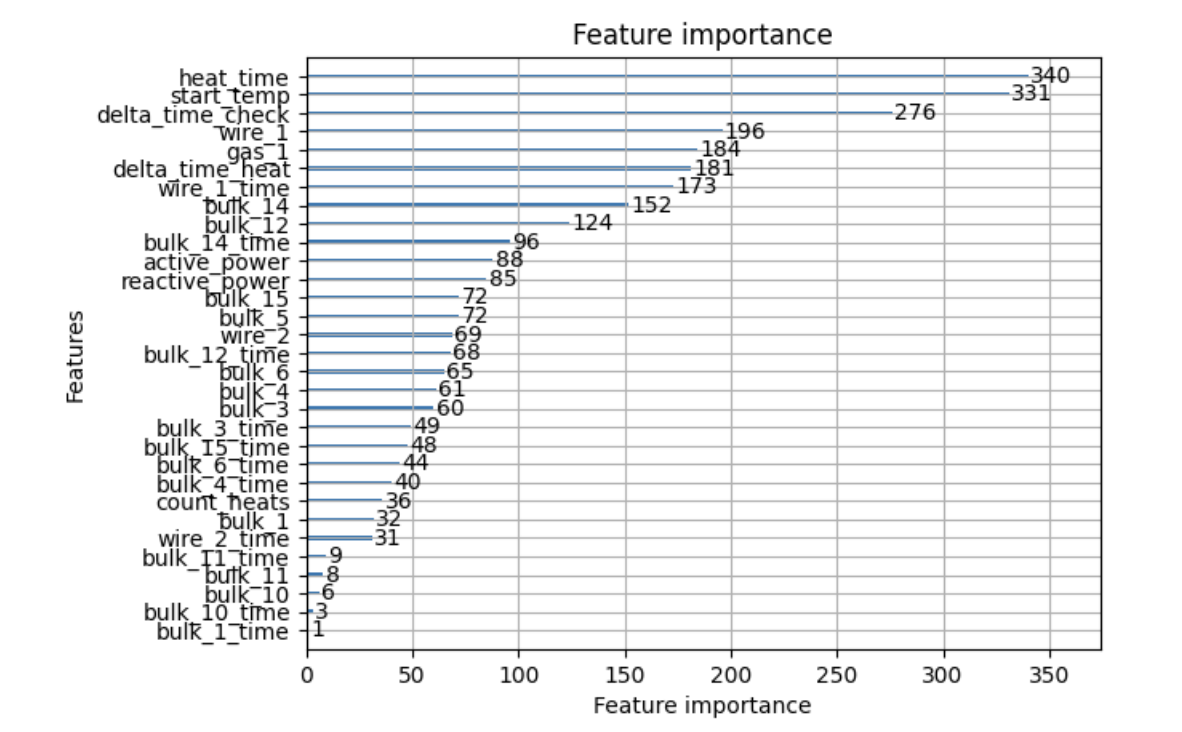

### 3. Развертывание модели

Разработанная программа представляет собой файл IPython notebook и требует наличия предустановленного на устройство Jupyter Notebook и соответствующих библиотек.

Запуск программы осуществляется при помощи двойного клика по файлу при запуске на локальном сервере  Jupyter Notebook.
